### Objective:
    Given is the nutritional value data of the Mcdonalds Menu in the United States.
    Using the said data the following objectives are to be archived:
        1. Identify a business question to be answered
        2. Identify a target variable to be predicted.
        2. Identify the features to be used to best predict the target variable.
        3. Implement a model to predict the target variable
#### High Level Tasks:
    1. Import and read data—Done
    2. Clean data and treat for any missing/non consistent values-Done
        1.No Missing Values Found
        2.Got the Magnitude and Unit for each serving.
        3.Added a Cnt Column equal to 1 for each record
        4.Made all the Continuous data the proper data types
            4.1 set all values to the same scale.
        5.aligned all the categorical to the left and continuous to the right
        6.Saved the dataset as csv as a check point.   
    3. Explore data using discrete statistic to understand the data better--WIP
    4. Send the project to the Team for review

In [9]:
# import all the supporting libaries
import pandas as pb #using pandas as it gives the flexibility of working and altering the data in a data frame
import re #using regex to be able to remove special characters.
import matplotlib.pyplot as plt #used for graphing and ploting

### Import Data

In [10]:
if 'df' in locals():
    del df
#Import and read data
df = pb.read_csv('McDonald_Menu.csv')

#### Clean up Column Names

In [11]:
#Clean data and treat for any missing/non consistant values
#Shorten Column Name to be more easy to read data

#reference : https://stackoverflow.com/questions/39741429/pandas-replace-a-character-in-all-column-names
#remove spaces from the column names
df.columns=df.columns.str.replace(" ", "_")


#replace _(%_Daily_Value) with  PrDV
df.columns=df.columns.str.replace("%_Daily_Value", "PrDV")
df.columns=df.columns.str.replace("[()]", "")

#Remove all the vowels in the column names
vowels=['a','e','i','o','u']
colmap = {}

for col in df.columns:
    col1=col
    for v in vowels:
        col1=col1.replace(v,'')
    colmap[col] = col1
df.columns = list(colmap.values())

#### Get the magniture and Unit for each serving

In [12]:
#Add Column serving magnitude and unit
    #Need to use the apply() function 
#Reference https://www.youtube.com/watch?v=eMOA1pPVUc4 [39:01]

#define funcition apply to get serviing size.
def serving_size_parse(ls_seving):
    mag_unit=[]
    serv_split = ls_seving.split()
    if 'g' == serv_split[-1].replace(')',''):
        mag = serv_split[-2].replace('(','')
        unit = serv_split[-1].replace(')','')
    elif 'cup' == serv_split[-1] :
        mag = serv_split[0]
        unit = serv_split[1] + serv_split[2]
    elif 'oz' == serv_split[-1]:
        mag = serv_split[0]
        unit = serv_split[1] + serv_split[2]
    elif 'carton' == serv_split[1]:
        mag = serv_split[-2].replace('(','')
        unit = serv_split[-1].replace(')','')
    elif  'fl' == serv_split[1]:
        mag = serv_split[-2].replace('(','')
        unit = serv_split[-1].replace(')','')
    else:
        mag = ''
        unit = ''
    mag_unit.append(ls_seving)
    mag_unit.append(mag)
    mag_unit.append(unit)
    return mag_unit

#Add Column serving magnitude and unit
#Populate the value using apply
df['Srvng_mag'] = 'Unknown'
df['Srvng_unit'] = 'Unknown'
df['Srvng_mag'] = df['Srvng_Sz'].apply(lambda x: serving_size_parse(x)[1])
df['Srvng_unit'] = df['Srvng_Sz'].apply(lambda x: serving_size_parse(x)[2])
df['Srvng_mag'] = df['Srvng_mag'].apply(lambda x: float(x))
df['Cnt'] = 1
#Change mg to g
df['Chlstrl']=df['Chlstrl'].apply(lambda x: float(x)/1000)
df['Sdm']=df['Sdm'].apply(lambda x: float(x)/1000)
#Change floz to ml
df.loc[df['Srvng_unit']=='floz','Srvng_mag'] = df['Srvng_mag'].apply(lambda x: float(x)*29.574)
df.loc[df['Srvng_unit']=='floz','Srvng_unit'] = 'ml'

#### Check for Missing Value

In [13]:
#Check for NaN and Null-No Missing Values Found
#Reference https://www.youtube.com/watch?v=eMOA1pPVUc4 [20:40]
nan_df = df[df.isna().any(axis=1)]
nan_df.head()

,Ctgry,Itm,Srvng_Sz,Clrs,Clrs_frm_Ft,Ttl_Ft,Ttl_Ft_PrDV,Strtd_Ft,Strtd_Ft_PrDV,Trns_Ft,...,Dtry_Fbr_PrDV,Sgrs,Prtn,Vtmn_A_PrDV,Vtmn_C_PrDV,Clcm_PrDV,Irn_PrDV,Srvng_mag,Srvng_unit,Cnt


#### Set the data proper datatype for the columns

In [14]:
#Loop Through all cols and set datatype as needed
#Reference : https://stackoverflow.com/questions/15891038/change-data-type-of-columns-in-pandas
    #https://www.w3resource.com/pandas/dataframe/dataframe-dtypes.php
numeric_col_ls = ['Clrs','Clrs_frm_Ft','Ttl_Ft','Ttl_Ft_PrDV','Strtd_Ft','Strtd_Ft_PrDV','Trns_Ft','Chlstrl','Chlstrl_PrDV','Sdm','Sdm_PrDV','Crbhydrts','Crbhydrts_PrDV','Dtry_Fbr','Dtry_Fbr_PrDV','Sgrs','Prtn','Vtmn_A_PrDV','Vtmn_C_PrDV','Clcm_PrDV','Irn_PrDV','Srvng_mag','Cnt']

for col in df.columns:
    if col in numeric_col_ls:
        pb.to_numeric(df[col])
df.to_csv('Cleaned.csv',index=False)
df.head()


,Ctgry,Itm,Srvng_Sz,Clrs,Clrs_frm_Ft,Ttl_Ft,Ttl_Ft_PrDV,Strtd_Ft,Strtd_Ft_PrDV,Trns_Ft,...,Dtry_Fbr_PrDV,Sgrs,Prtn,Vtmn_A_PrDV,Vtmn_C_PrDV,Clcm_PrDV,Irn_PrDV,Srvng_mag,Srvng_unit,Cnt
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,...,17,3,17,10,0,25,15,136.0,g,1
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,...,17,3,18,6,0,25,8,135.0,g,1
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,...,17,2,14,8,0,25,10,111.0,g,1
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,...,17,2,21,15,0,30,15,161.0,g,1
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,...,17,2,21,6,0,25,10,161.0,g,1


#### Aligned all the dimensions to the left and facts to the right

In [15]:
cols =  df.columns.tolist()

valcols = ['Ctgry','Itm','Srvng_unit','Srvng_mag','Clrs','Clrs_frm_Ft','Ttl_Ft','Strtd_Ft','Trns_Ft','Chlstrl','Sdm','Crbhydrts','Dtry_Fbr','Sgrs','Prtn']
dvcols = ['Ctgry','Itm','Srvng_unit','Srvng_mag','Ttl_Ft_PrDV','Strtd_Ft_PrDV','Chlstrl_PrDV','Sdm_PrDV','Crbhydrts_PrDV','Dtry_Fbr_PrDV','Vtmn_A_PrDV','Vtmn_C_PrDV','Clcm_PrDV','Irn_PrDV']

Nval = df[valcols]
dNval = df[dvcols]

Nval.to_csv('Nval.csv',index=False)
dNval.to_csv('dNval.csv',index=False)

#### Explore the data statictically

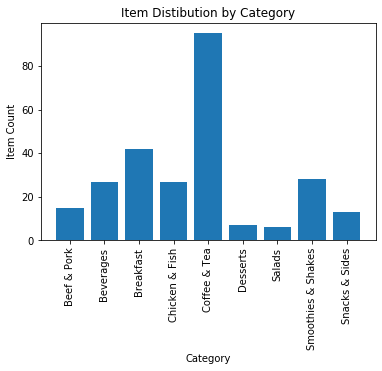

In [16]:
#Start Ploting and Exploring the data.
#Reference : https://www.youtube.com/watch?v=eMOA1pPVUc4&t=1240s [31:12]
    #https://www.youtube.com/watch?v=DAQNHzOcO5A
results=Nval.groupby('Ctgry').count()
x = [cat for cat, df in Nval.groupby('Ctgry')]
y = results['Itm']
r = 'vertical'
title = 'Item Distibution by Category'
xlabel = 'Category'
ylabel = 'Item Count'

plt.bar(x,y)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(x,rotation=r)
plt.show()